<table>
<tr><td><img style="height: 150px;" src="images/geo_hydro1.jpg"></td>
<td bgcolor="#FFFFFF">
    <p style="font-size: xx-large; font-weight: 900; line-height: 100%">pySTALAGMITE</p>
    <p style="font-size: large; color: rgba(0,0,0,0.5);"><b style=color:red;>STALAGMITE</b> modelling</p>
    <p style="font-size: large; color: rgba(0,0,0,0.5);">Georg Kaufmann</p>
    </td>
<td><img style="height: 150px;" src="images/pySTALAGMITE.png"></td>
</tr>
</table>

----
# `pySTALAGMITE`

pySTALAGMITE, a program package prediction the shape of a stalagmite from pre-defined climate conditions.

In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import sys

import libCHEM,libSTALAGMITE

----
# Run `pySTALAGMITE`

Now we have assembed and discussed all relevant functions.

We group the functions in a wrapper function, `pySTALAGMITE()`.
Three options are passed:
- `infile`: name of parameter file
- `path`: path to parameter file
- `mix`: mixing between open(mix=1) and closed (mix=0) system

In [2]:
def STALAGMITE_FLOW(infile1='STALAGMITE_parameter.in',infile2='STALAGMITE_timeline.in',path='work/',mix=0.5,climate='simple'):
    #---------------------
    # initial setup
    #---------------------
    Vdrop    = 0.1e-6  # drop volume [m3]
    rhoWater = 1000.   # density water [kg/m3]
    g        = 9.81    # grav acceleration [m/s2]
    etaWater = 1.14e-3 # viscosity water [Pas]
    mCaCO3   = 0.1001  # molar mass calcite [kg/mol]
    rhoCaCO3 = 2700.   # density calcite [kg/m3]
    year2sec = 365.25*24*60*60
    sidex,nx,init_height,timeStep,timeWrite,TSoilmin,TSoilmax,PSoilmin,PSoilmax, \
            PAtmmin,PAtmmax,TCavemin,TCavemax,PCavemin,PCavemax,dropCavemin,dropCavemax = \
            libSTALAGMITE.readParameter2D(infile=infile1,path=path,control=True)
    timeStart,timeEnd,rawTimeline = libSTALAGMITE.readTimeline2D(infile=infile2,path=path,control=True)
    x,y,dx = libSTALAGMITE.createGrid2D(sidex,nx,init_height=init_height,plot=False)
    # define stack for geometry
    nstack = 50
    stal   = np.zeros(nx*2*nstack).reshape(nx,2,nstack)
    tSaved = np.zeros(nstack)
    stal[:,0,0] = x
    stal[:,1,0] = y
    tSaved[0]   = timeStart
    #---------------------
    # time loop
    #---------------------
    iSaved = 0
    itime  = 0
    time   = timeStart+ timeStep
    while (time <= timeEnd):
        # climate parameter
        if (climate == 'simple'):
            TSoil = np.interp(time,[timeStart,timeEnd],[TSoilmin,TSoilmax])
            TCave = np.interp(time,[timeStart,timeEnd],[TCavemin,TCavemax])
            PSoil = np.interp(time,[timeStart,timeEnd],[PSoilmin,PSoilmax])
            PCave = np.interp(time,[timeStart,timeEnd],[PCavemin,PCavemax])
            DCave = np.interp(time,[timeStart,timeEnd],[dropCavemin,dropCavemax])
        elif (climate == 'steps'):
            TSoil = np.interp(time,rawTimeline[:,0],rawTimeline[:,1])
            TCave = np.interp(time,[timeStart,timeEnd],[TCavemin,TCavemax])
            PSoil = np.interp(time,[timeStart,timeEnd],[PSoilmin,PSoilmax])
            PCave = np.interp(time,[timeStart,timeEnd],[PCavemin,PCavemax])
            DCave = np.interp(time,[timeStart,timeEnd],[dropCavemin,dropCavemax])
        elif (climate == 'paleo'):
            TSoil = np.interp(time,rawTimeline[:,0],rawTimeline[:,1])
            TCave = TCavemin+ (TCavemax-TCavemin) * (TSoil-TSoilmin)/(TSoilmax-TSoilmin)
            PSoil = PSoilmin+ (PSoilmax-PSoilmin) * (TSoil-TSoilmin)/(TSoilmax-TSoilmin)
            PCave = PCavemin+ (PCavemax-PCavemin) * (TSoil-TSoilmin)/(TSoilmax-TSoilmin)
            DCave = DCavemin+ (DCavemax-DCavemin) * (TSoil-TSoilmin)/(TSoilmax-TSoilmin)
        Q     = Vdrop / DCave
        # drop chemistry
        CEQopen   = libCHEM.CEQ_limestone_open(TSoil,PSoil/1e6)
        CEQclosed = libCHEM.CEQ_limestone_closed(TSoil,PSoil/1e6)
        Cin       = mix*CEQopen + (1-mix)*CEQclosed
        CEQcave   = 1.12 * libCHEM.CEQ_limestone_open(TCave,PCave/1e6)
        # growth rate and equilibrium radius
        W0 = libSTALAGMITE.growthRate2D(Cin,CEQcave,DCave,TSoil)
        R0 = libSTALAGMITE.equiRadius2D(Cin,CEQcave,DCave,TSoil)
        # refine grid    
        if (x[1] > 1.5*dx):
            x,y = libSTALAGMITE.refineGrid2D(x,y)
        # loop along surface
        growth = np.zeros(len(x))
        angle  = np.zeros(len(x))
        width  = np.zeros(len(x))
        flux   = np.zeros(len(x))
        film   = np.zeros(len(x))
        vel    = np.zeros(len(x))
        c      = np.zeros(len(x))
        t      = np.zeros(len(x))
        # calcium concentration, flux rate, and growth rate along tip
        c[0]      = Cin
        flux[0]   = libSTALAGMITE.FCaCO3(Cin,CEQcave,TSoil)
        growth[0] = mCaCO3 / rhoCaCO3 * flux[0] * timeStep * year2sec
        # loop along surface
        angle[0]  = 0.
        for i in range(1,len(x)):
            dl       = np.sqrt( (x[i-1]-x[i])**2 + (y[i-1]-y[i])**2)
            width[i] = 2.*np.pi*x[i]
            angle[i] = np.arcsin((y[i-1]-y[i])/dl)
            if (angle[i] > 0.):
                film[i]  = np.cbrt(3*etaWater/(rhoWater*g) * Q / (width[i]*np.sin(angle[i])))
                vel[i]   = np.cbrt(rhoWater*g/(3*etaWater) * Q**2*np.sin(angle[i])/(width[i]**2))
                t[i]     = t[i-1] + dl/vel[i]
                c[i]     = c[i-1] - flux[i-1]/vel[i]/film[i]*dl
            else:
                t[i]     = t[i-1]
                c[i]     = c[i-1]
            flux[i]   = libSTALAGMITE.FCaCO3(c[i],CEQcave,TSoil)
            growth[i] = mCaCO3 / rhoCaCO3 * flux[i] * timeStep * year2sec
        # update shape
        x[0]      = x[0]
        y[0]      = y[0] + growth[0]
        for i in range(1,len(x)):
            x[i] = x[i] + growth[i]*np.sin(angle[i])
            y[i] = y[i] + growth[i]*np.cos(angle[i])
        vel[0]  = vel[1]
        film[0] = film[1]    
        # save time step
        if (time % timeWrite == 0):
            iSaved = iSaved + 1
            if (iSaved > stal.shape[2]-1):
                print('iSaved too large')
                sys.exit()
            print('%30s %10i %10.2f %10.2f' % ('Time step, time [a], TSoil [C]:',iSaved,time,TSoil))
            stal[:,0,iSaved] = x
            stal[:,1,iSaved] = y
            tSaved[iSaved] = time
        # update time step
        time += timeStep
        itime += 1
    #---------------------
    # plot shape
    #---------------------
    libSTALAGMITE.plotStalagmite2D(stal,iSaved,tSaved,sidex)
    return sidex,stal,iSaved,tSaved

== STALAGMITE ==
                         path:     div/run_simple1/
                 sidex [m],nx:       0.40        801
              init_height [m]:       0.01
       timestep,timewrite [a]:      10.00      1000.00
        TSoilmin,TSoilmax [C]:      10.00        10.00
      PSoilmin,PSoilmax [ppm]:   30000.00     30000.00
        PAtmmin,PAtmmax [ppm]:     400.00       400.00
        TCavemin,TCavemax [C]:      10.00        10.00
      PCavemin,PCavemax [ppm]:     400.00       400.00
  dropCavemin,dropCavemax [s]:     100.00       100.00
        timeStart,timeEnd [a]:  -10000.00         0.00
Time step, time [a], TSoil [C]:          1   -9000.00      10.00
Time step, time [a], TSoil [C]:          2   -8000.00      10.00
Time step, time [a], TSoil [C]:          3   -7000.00      10.00
Time step, time [a], TSoil [C]:          4   -6000.00      10.00
Time step, time [a], TSoil [C]:          5   -5000.00      10.00
Time step, time [a], TSoil [C]:          6   -4000.00      10.00
Time s

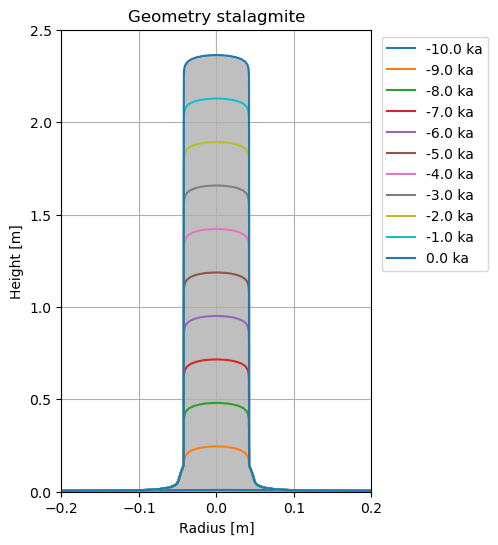

In [3]:
sidex,stal,iSaved,tSaved = STALAGMITE_FLOW(path='div/run_simple1/',climate='simple')

== STALAGMITE ==
                         path:     div/run_simple2/
                 sidex [m],nx:       0.40        801
              init_height [m]:       0.01
       timestep,timewrite [a]:      10.00      1000.00
        TSoilmin,TSoilmax [C]:       0.00        10.00
      PSoilmin,PSoilmax [ppm]:   30000.00     30000.00
        PAtmmin,PAtmmax [ppm]:     400.00       400.00
        TCavemin,TCavemax [C]:      10.00        10.00
      PCavemin,PCavemax [ppm]:     400.00       400.00
  dropCavemin,dropCavemax [s]:     100.00       100.00
        timeStart,timeEnd [a]:  -10000.00         0.00
Time step, time [a], TSoil [C]:          1   -9000.00       1.00
Time step, time [a], TSoil [C]:          2   -8000.00       2.00
Time step, time [a], TSoil [C]:          3   -7000.00       3.00
Time step, time [a], TSoil [C]:          4   -6000.00       4.00
Time step, time [a], TSoil [C]:          5   -5000.00       5.00
Time step, time [a], TSoil [C]:          6   -4000.00       6.00
Time s

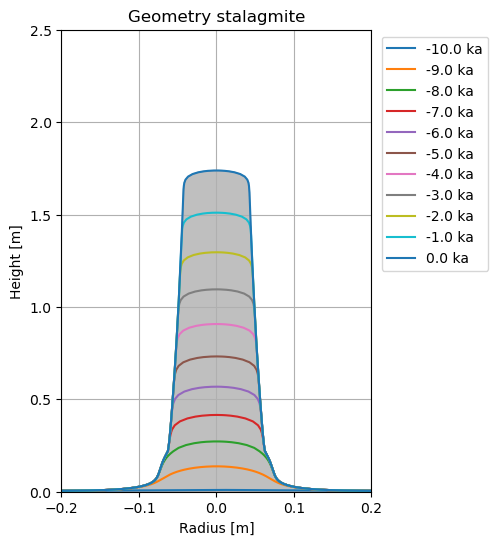

In [4]:
sidex,stal,iSaved,tSaved = STALAGMITE_FLOW(path='div/run_simple2/',climate='simple')

== STALAGMITE ==
                         path:     div/run_simple3/
                 sidex [m],nx:       0.40        801
              init_height [m]:       0.01
       timestep,timewrite [a]:      10.00      1000.00
        TSoilmin,TSoilmax [C]:      10.00        10.00
      PSoilmin,PSoilmax [ppm]:     400.00     30000.00
        PAtmmin,PAtmmax [ppm]:     400.00       400.00
        TCavemin,TCavemax [C]:      10.00        10.00
      PCavemin,PCavemax [ppm]:     400.00       400.00
  dropCavemin,dropCavemax [s]:     100.00       100.00
        timeStart,timeEnd [a]:  -10000.00         0.00
Time step, time [a], TSoil [C]:          1   -9000.00      10.00
Time step, time [a], TSoil [C]:          2   -8000.00      10.00
Time step, time [a], TSoil [C]:          3   -7000.00      10.00
Time step, time [a], TSoil [C]:          4   -6000.00      10.00
Time step, time [a], TSoil [C]:          5   -5000.00      10.00
Time step, time [a], TSoil [C]:          6   -4000.00      10.00
Time s

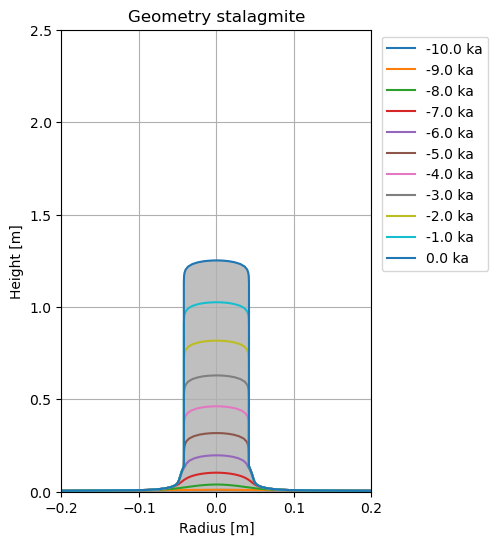

In [5]:
sidex,stal,iSaved,tSaved = STALAGMITE_FLOW(path='div/run_simple3/',climate='simple')

== STALAGMITE ==
                         path:     div/run_simple4/
                 sidex [m],nx:       0.40        801
              init_height [m]:       0.01
       timestep,timewrite [a]:      10.00      1000.00
        TSoilmin,TSoilmax [C]:      10.00        10.00
      PSoilmin,PSoilmax [ppm]:   30000.00     30000.00
        PAtmmin,PAtmmax [ppm]:     400.00       400.00
        TCavemin,TCavemax [C]:      10.00        10.00
      PCavemin,PCavemax [ppm]:     400.00       400.00
  dropCavemin,dropCavemax [s]:    1000.00       100.00
        timeStart,timeEnd [a]:  -10000.00         0.00
Time step, time [a], TSoil [C]:          1   -9000.00      10.00
Time step, time [a], TSoil [C]:          2   -8000.00      10.00
Time step, time [a], TSoil [C]:          3   -7000.00      10.00
Time step, time [a], TSoil [C]:          4   -6000.00      10.00
Time step, time [a], TSoil [C]:          5   -5000.00      10.00
Time step, time [a], TSoil [C]:          6   -4000.00      10.00
Time s

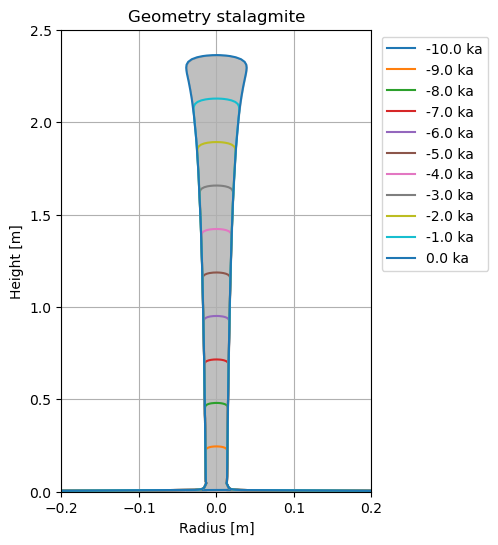

In [6]:
sidex,stal,iSaved,tSaved = STALAGMITE_FLOW(path='div/run_simple4/',climate='simple')

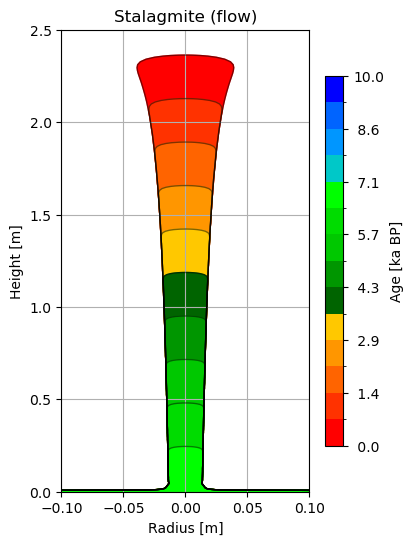

In [72]:
import matplotlib
colors = [
( 0 , 0 , 1 ),
( 0 , 0.196078 , 1 ),
( 0 , 0.392157 , 1 ),
( 0 , 0.588235 , 1 ),
( 0 , 0.784314 , 0.784314 ),
( 0 , 1 , 0 ),
( 0 , 0.862745 , 0 ),
( 0 , 0.784314 , 0 ),
( 0 , 0.588235 , 0 ),
( 0 , 0.392157 , 0 ),
( 1 , 0.784314 , 0 ),
( 1 , 0.588235 , 0 ),
( 1 , 0.392157 , 0 ),
( 1 , 0.196078 , 0 ),
( 1 , 0 , 0 )]
cmap = matplotlib.colors.ListedColormap(colors[::-1])
ncolors = cmap.N
#cmap = plt.get_cmap('tab20', ncolors)
bounds = np.linspace(0,10, ncolors)
norm = mpl.colors.BoundaryNorm(bounds,ncolors)

plt.figure(figsize=(4,6))
plt.title('Stalagmite (flow)')
plt.xlim([-sidex/4,sidex/4])
plt.ylim([0.0,2.5])
plt.xlabel('Radius [m]')
plt.ylabel('Height [m]')
for i in range(iSaved,0,-1):
    t = int(-tSaved[i]/1000)
    x  = np.r_[-stal[:,0,i][::-1],stal[:,0,i]]
    y1 = np.r_[stal[:,1,i][::-1],stal[:,1,i]]
    y2 = np.r_[stal[:,1,i-1][::-1],stal[:,1,i-1]]
    cs1=plt.fill_between(x,y1,0,cmap=cmap,color=cmap.colors[t],norm=norm,alpha=1)
    plt.plot(x,y1,lw=1,color='black',alpha=0.5)
plt.colorbar(cs1,shrink=0.8,format='%4.1f',label='Age [ka BP]')
plt.grid()

----